In [1]:
import os
import numpy as np
import nibabel as nib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
import tensorflow as tf
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
x_path = 'data/2/rp_im'
y_path = 'data/2/rp_msk'
l_path = 'data/2/rp_lung_msk'

In [3]:
for i in range(9):
    curr_x = nib.load(x_path + '/' + str(i+1) + '.nii').get_fdata()
    curr_y = nib.load(y_path + '/' + str(i+1) + '.nii').get_fdata()
    curr_l = nib.load(l_path + '/' + str(i+1) + '.nii').get_fdata()
    
    if i == 0:
        x = curr_x
        y = curr_y
        l = curr_l
    else:
        x = np.concatenate((x, curr_x), axis=2)
        y = np.concatenate((y, curr_y), axis=2)
        l = np.concatenate((l, curr_l), axis=2)

<h4>Data has already been preprocessed with <a href="https://medium.com/@hbjenssen/covid-19-radiology-data-collection-and-preparation-for-artificial-intelligence-4ecece97bb5b">these</a> steps, except for the resize</h4>

In [4]:
print(x.shape)
print(y.shape)
print(l.shape)

x = x.T
y = y.T
l = l.T

print(x.shape)
print(y.shape)
print(l.shape)

(630, 630, 829)
(630, 630, 829)
(630, 630, 829)
(829, 630, 630)
(829, 630, 630)
(829, 630, 630)


In [8]:
from skimage.transform import resize
num_of_imgs = np.size(x, axis=2)

resized_x = np.zeros((num_of_imgs, 512, 512, 1))
resized_y = np.zeros((num_of_imgs, 512, 512, 1))
resized_l = np.zeros((num_of_imgs, 512, 512, 1))

all_data = [[x, resized_x], [y, resized_y], [l, resized_l]]

for data in all_data:
    for i in range(num_of_imgs):
        resized_img = resize(data[0][i], (512, 512), preserve_range=True)
        
        #flipped_resized_img = np.fliplr(np.rot90(resized_img, k=3))

        data[1][i] = img_to_array(resized_img)
    

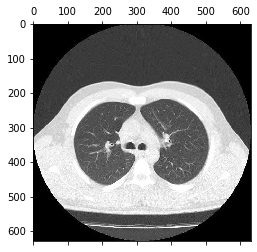

In [12]:
fig, ax = plt.subplots(1)
ax.matshow(x[70], cmap='gray')

(630, 512, 512, 1)
(512, 512, 1)


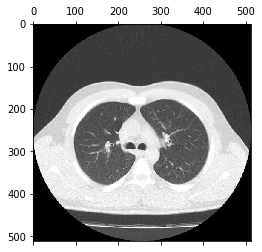

In [11]:
print(resized_x.shape)
print(resized_x[70].shape)
fig, ax = plt.subplots(1)
ax.matshow(array_to_img(resized_x[70]), cmap='gray')

In [13]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [20]:
seed = 1
image_datagen.fit(resized_x[:10], augment=True, seed=seed)
mask_datagen.fit(resized_y[:10], augment=True, seed=seed)

In [15]:
img_width = 512
img_height = 512
img_channels = 1

# build model
inputs = tf.keras.layers.Input((img_width, img_height, img_channels))

# contractive path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
image_generator = image_datagen.flow(
    resized_x[:10],
    batch_size=1,
    seed=seed)

mask_generator = mask_datagen.flow(
    resized_y[:10],
    batch_size=1,
    seed=seed)

print(np.size(image_generator))
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

#model.fit(train_generator,epochs=2)